In [ ]:
# import os
# os.environ["WANDB_MODE"]='offline'

In [ ]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from fastai.callback.wandb import *
from fastai.vision.all import *

from FastFF.utils import *
from FastFF.models.general import *

In [ ]:
torch.set_default_device('cuda:1')
torch.cuda.set_device('cuda:1')

# MNIST expertiments

In [ ]:
sweep_cfg = {
    'method': 'grid',
    'metric':{'name': 'valid_loss','goal':'minimize'},
    'parameters':{
        'dataset': {'value': 'CIFAR10'},
        'bs': {'value': 128},
        'learn':{'parameters':{'lr_max': {'value':8e-4}}},
        'model':{'parameters':{
            'h': {'values': [8,16,32]},
            'd': {'values': [1,2,3,4]},
            'act': {'value': 'relu'},
            'model_type': {'values': ['moe-soft', 'fff-soft', 'fff', 'moe-top1']}
            }},
        'epochs': {'value': 25}
    }
}

def run(cfg, run):
    run.name = ' '.join(f'{k}={v}' for k,v in cfg.model.items())
    h,d = cfg.model['h'], cfg.model['d']
    in_dim, out_dim = 32*32*3, 10
    if cfg.model['model_type'] == 'moe-soft':
        model = GeneralMoE(GateMoESoft(in_dim, 2**d), 
                   SoftMergingExperts(2**d, in_dim, out_dim, h), save_probs=True)
    elif cfg.model['model_type'] == 'moe-top1':
        model = GeneralMoE(GateMoE(in_dim, 2**d, top_k=1), TopkExperts(2**d, in_dim, out_dim, h), save_probs=True)
    elif cfg.model['model_type'] == 'fff-soft':
        model = GeneralMoE(GateFFF(in_dim, d), SoftMergingExperts(2**d, in_dim, out_dim, h), save_probs=True)
    elif cfg.model['model_type'] == 'fff':
        model = GeneralMoE(GateFFF(in_dim, d), TopkExperts(2**d, in_dim, out_dim, h), save_probs=True)
    model = torch.compile(model)
    
    cbs = [TinyWandbCallback(log_preds=False), ProbsDistrCB(wandb = True, sample_size=100, image_shape=(3,32,32))]
    learn = Learner(get_cifar_dls(cfg.bs), model, F.cross_entropy, metrics=accuracy, cbs=cbs)
    learn.fit_one_cycle(cfg.epochs, lr_max=cfg.learn['lr_max'])

In [ ]:
runs_sweep(sweep_cfg, 'FFF', 48, "Soft merging comparisons")(run)

In [ ]:
bs = 256
in_dim=28*28
out_dim=10
h_dim=32
depth=3
dls = get_mnist_dls(bs)

In [ ]:
model = GeneralMoE(GateFFF(in_dim, depth), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim), save_probs=True)
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model), GetGradCB([model.gate.nodes]), ShowGraphCallback()]
dls = get_mnist_dls(bs)
Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=1e-2)

In [ ]:
def summary():
    axes = subplots(ncols=2, figsize=(12,4))[1]
    axes[0].title.set_text('nodes')
    cbs[1].show(model.gate.nodes, lambda x: x.abs().mean(-1), ax=axes[0])
    cbs[0].show(-1, ax=axes[1])

epoch,train_loss,valid_loss,accuracy,time
0,0.604958,1.701688,0.695000,00:21
1,0.302282,0.750761,0.833300,00:16
2,0.216696,0.524621,0.870100,00:18
3,0.164715,0.558846,0.875000,00:17
4,0.133393,0.552776,0.877200,00:17


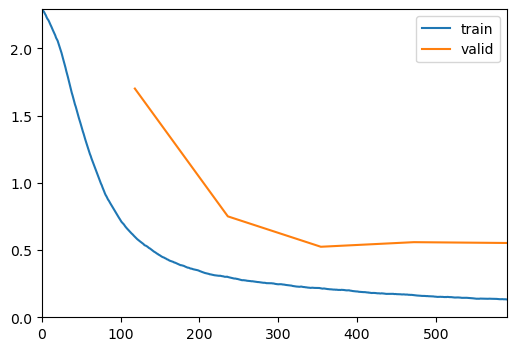

In [ ]:
model = GeneralMoE(GateFFF(in_dim, depth), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim, save_probs=True))
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model.experts), GetGradCB([model.gate.nodes]), ShowGraphCallback()]
Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=1e-2)

In [ ]:
summary()

epoch,train_loss,valid_loss,accuracy,time
0,0.615206,1.055282,0.722800,00:24
1,0.342229,1.495477,0.673600,00:17
2,0.247750,0.986513,0.744700,00:17
3,0.202701,0.911428,0.752400,00:18
4,0.169319,0.858024,0.767900,00:19


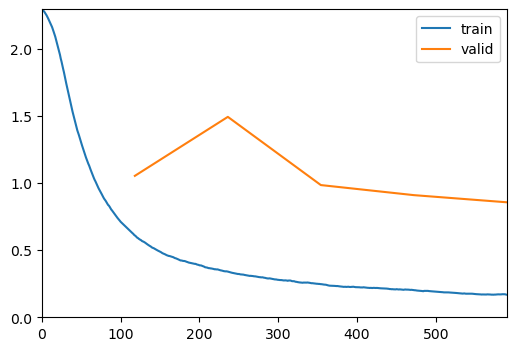

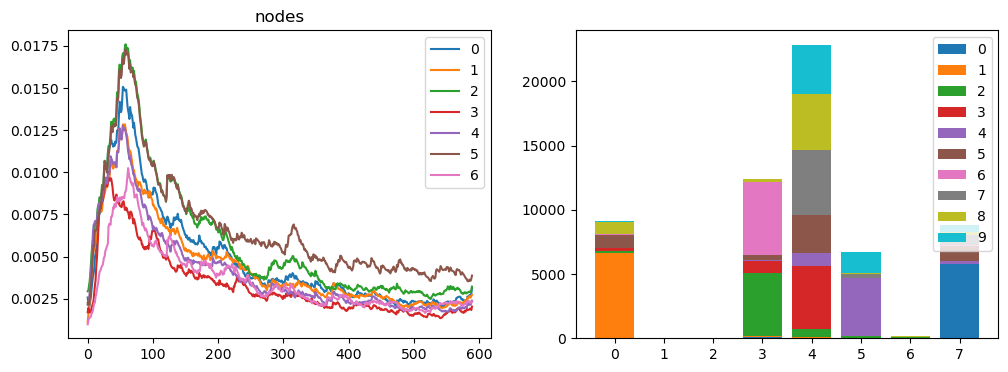

In [ ]:
model = GeneralMoE(GateFFF(in_dim, depth, tree_act=nn.ReLU()), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim, save_probs=True))
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model.experts), GetGradCB([model.gate.nodes]), ShowGraphCallback()]
Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=1e-2)
summary()

epoch,train_loss,valid_loss,accuracy,time
0,0.612143,0.550316,0.851500,00:30
1,0.313795,0.529659,0.840500,00:17
2,0.244149,0.305996,0.915500,00:17
3,0.207085,0.355595,0.899500,00:16
4,0.175706,0.304913,0.914400,00:22


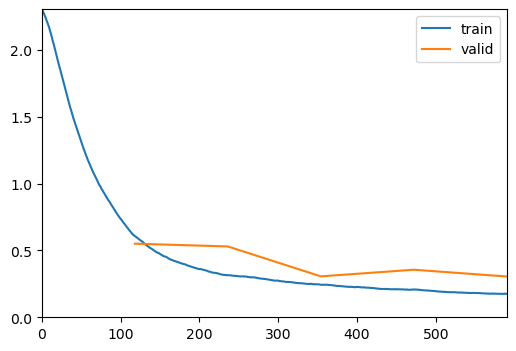

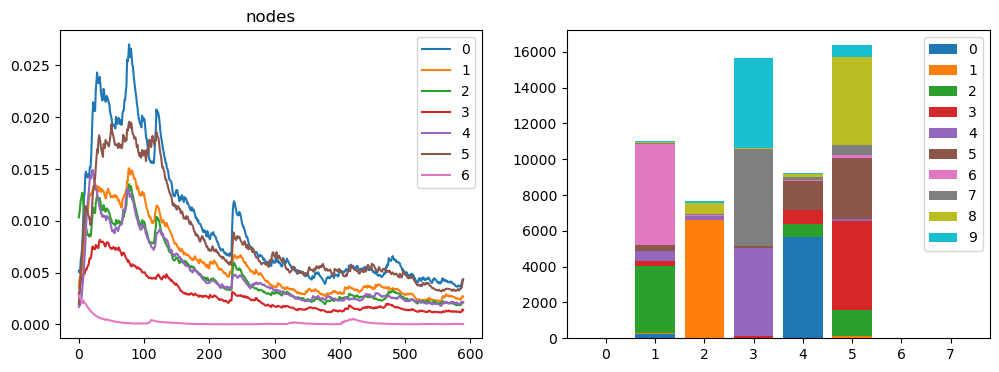

In [ ]:
model = GeneralMoE(GateFFF(in_dim, depth, tree_act=nn.Identity()), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim, save_probs=True))
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model.experts), GetGradCB([model.gate.nodes]), ShowGraphCallback()]
Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=1e-2)
summary()

In [ ]:
model = GeneralMoE(GateMoE(in_dim, 2**depth, top_k=2**depth), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim), save_probs=True)
# model = torch.compile(model)
cbs = [ProbsDistrCB(module=model), ShowGraphCallback()]
Learner(get_mnist_dls(bs,0), model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=1e-2)

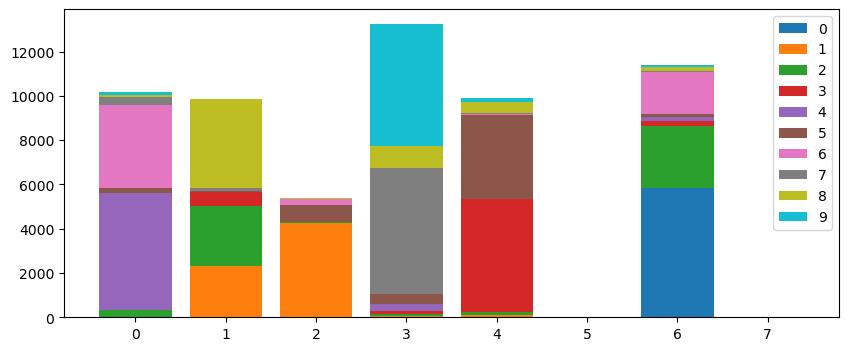

In [ ]:
cbs[0].show(-1, figsize=(10,4))

# CIFAR10

In [ ]:
bs = 64
in_dim=32*32*3
out_dim=10
h_dim=32
depth=3

model = GeneralMoE(GateFFF(in_dim, depth), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim, save_probs=True)).cuda()
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model.experts), GetGradCB([model.gate.nodes])]
dls = get_cifar_dls(bs, tfms=[lambda x: x.flatten()])
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs)
with learn.removed_cbs(Recorder):
    learn.fit_one_cycle(15, lr_max=8e-4, cbs=Recorder(add_time=False, train_metrics=True))

Files already downloaded and verified
Files already downloaded and verified


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy
0,1.722581,0.335220,1.891549,0.352200
1,1.716214,0.416380,1.917048,0.365700
2,1.699973,0.419040,1.832727,0.369100
3,1.643301,0.435640,1.890391,0.393700
4,1.560293,0.458280,1.768682,0.412600
5,1.499188,0.483020,1.797872,0.416500
6,1.408098,0.508360,1.765724,0.431300
7,1.347976,0.527920,1.749176,0.433600
8,1.302033,0.552160,1.709559,0.441100
9,1.230169,0.573080,1.803762,0.439600


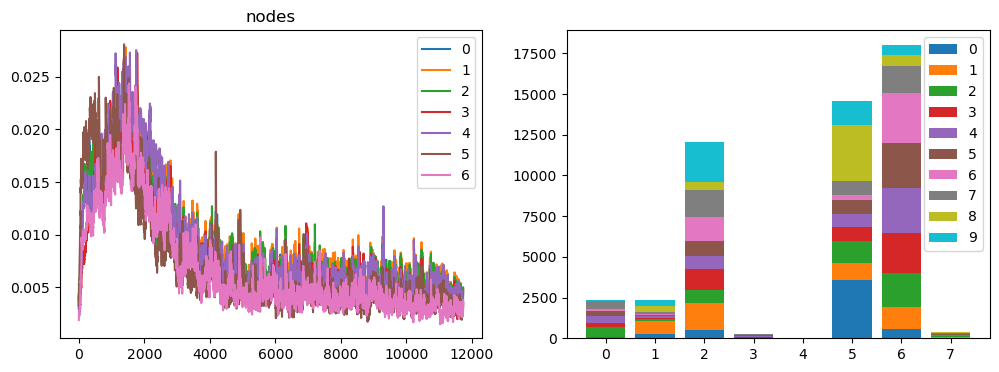

In [ ]:
summary()

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy
0,1.764064,0.333140,1.907784,0.331500
1,1.658545,0.418020,1.811494,0.381200
2,1.636515,0.442760,1.858356,0.393900
3,1.610460,0.453100,1.856231,0.406600
4,1.613844,0.451900,1.858561,0.398300
5,1.611729,0.462100,1.826297,0.413300
6,1.521950,0.472920,1.754513,0.416800
7,1.505186,0.492280,1.732492,0.427300
8,1.437173,0.510300,1.716421,0.441300
9,1.411806,0.530000,1.720239,0.441200


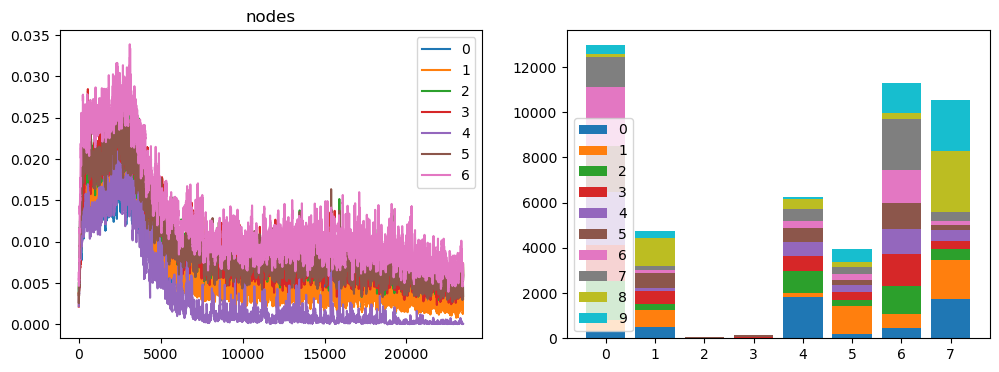

In [ ]:
model = GeneralMoE(GateFFF(in_dim, depth, nn.ReLU()), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim, save_probs=True)).cuda()
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model.experts), GetGradCB([model.gate.nodes])]
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs)
with learn.removed_cbs(Recorder):
    learn.fit_one_cycle(30, lr_max=8e-4, cbs=Recorder(add_time=False, train_metrics=True))
summary()

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy
0,1.763582,0.341360,1.783259,0.380300
1,1.667998,0.418580,1.748337,0.400500
2,1.615482,0.438740,1.739490,0.408600
3,1.609500,0.443620,1.743148,0.418900
4,1.583405,0.451620,1.724946,0.417100
5,1.581538,0.462660,1.692361,0.429500
6,1.488332,0.477160,1.712034,0.429000
7,1.478049,0.491360,1.642339,0.449900
8,1.436550,0.508200,1.662760,0.446600
9,1.415506,0.522320,1.689508,0.444500


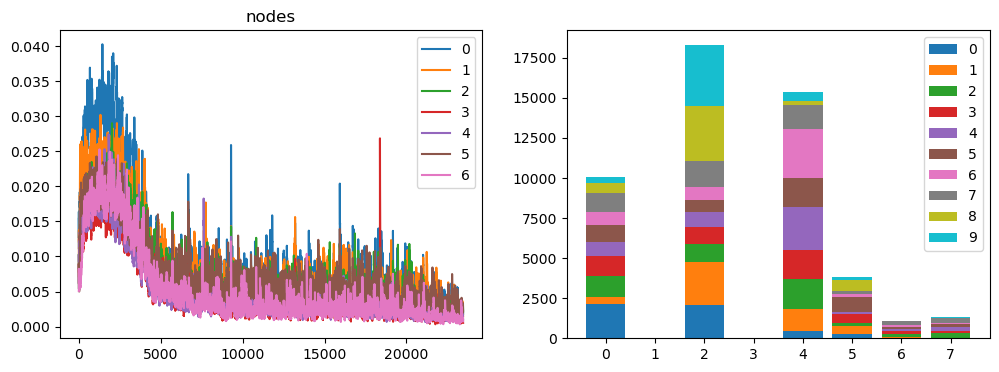

In [ ]:
model = GeneralMoE(GateFFF(in_dim, depth, nn.Identity()), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim, save_probs=True)).cuda()
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model.experts), GetGradCB([model.gate.nodes])]
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs)
with learn.removed_cbs(Recorder):
    learn.fit_one_cycle(30, lr_max=8e-4, cbs=Recorder(add_time=False, train_metrics=True))
summary()

In [ ]:
model = GeneralMoE(GateMoE(in_dim, 2**depth), 
                   SoftMergingExperts(2**depth, in_dim, out_dim, h_dim, save_probs=True)).cuda()
model = torch.compile(model)
cbs = [ProbsDistrCB(module=model.experts), GetGradCB([model.gate])]
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs)
with learn.removed_cbs(Recorder):
    learn.fit_one_cycle(30, lr_max=8e-4, cbs=Recorder(add_time=False, train_metrics=True))
summary()

# Visualize

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import wandb

api = wandb.Api()
sweep = api.sweep("slakter/FFF/sweeps/5yb9x2nq")

In [ ]:
models = {'moe-soft':[], 'fff-soft':[], 'fff':[], 'moe-top1':[]}
params = ['d','h']
metrics = ['train_loss', 'valid_loss', 'accuracy']


def plot_summary(fixed, axes):
    models = {'moe-soft':[], 'fff-soft':[], 'fff':[], 'moe-top1':[]}
    params = ['d','h']
    metrics = ['train_loss', 'valid_loss', 'accuracy']
    for run in sweep.runs:
        cfg = run.config['model']
        if any(cfg[p]!=v for p,v in fixed.items()): continue
        m = cfg['model_type']
        res = {k: run.summary[k] for k in metrics}
        for p in params: res[p] = cfg[p]
        models[m].append(res)
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.set_title(f'')
        ax.grid()
        ax.set_label(metric)
        ax.set_xlabel('d')
        ax.set_ylabel(metric)
        for m, l in models.items():
            xs = list(map(lambda x: x['d'], l))
            ys = list(map(lambda x: x[metric], l))
            ax.plot(xs, ys, label = m)
            ax.scatter(xs, ys)

<matplotlib.legend.Legend>

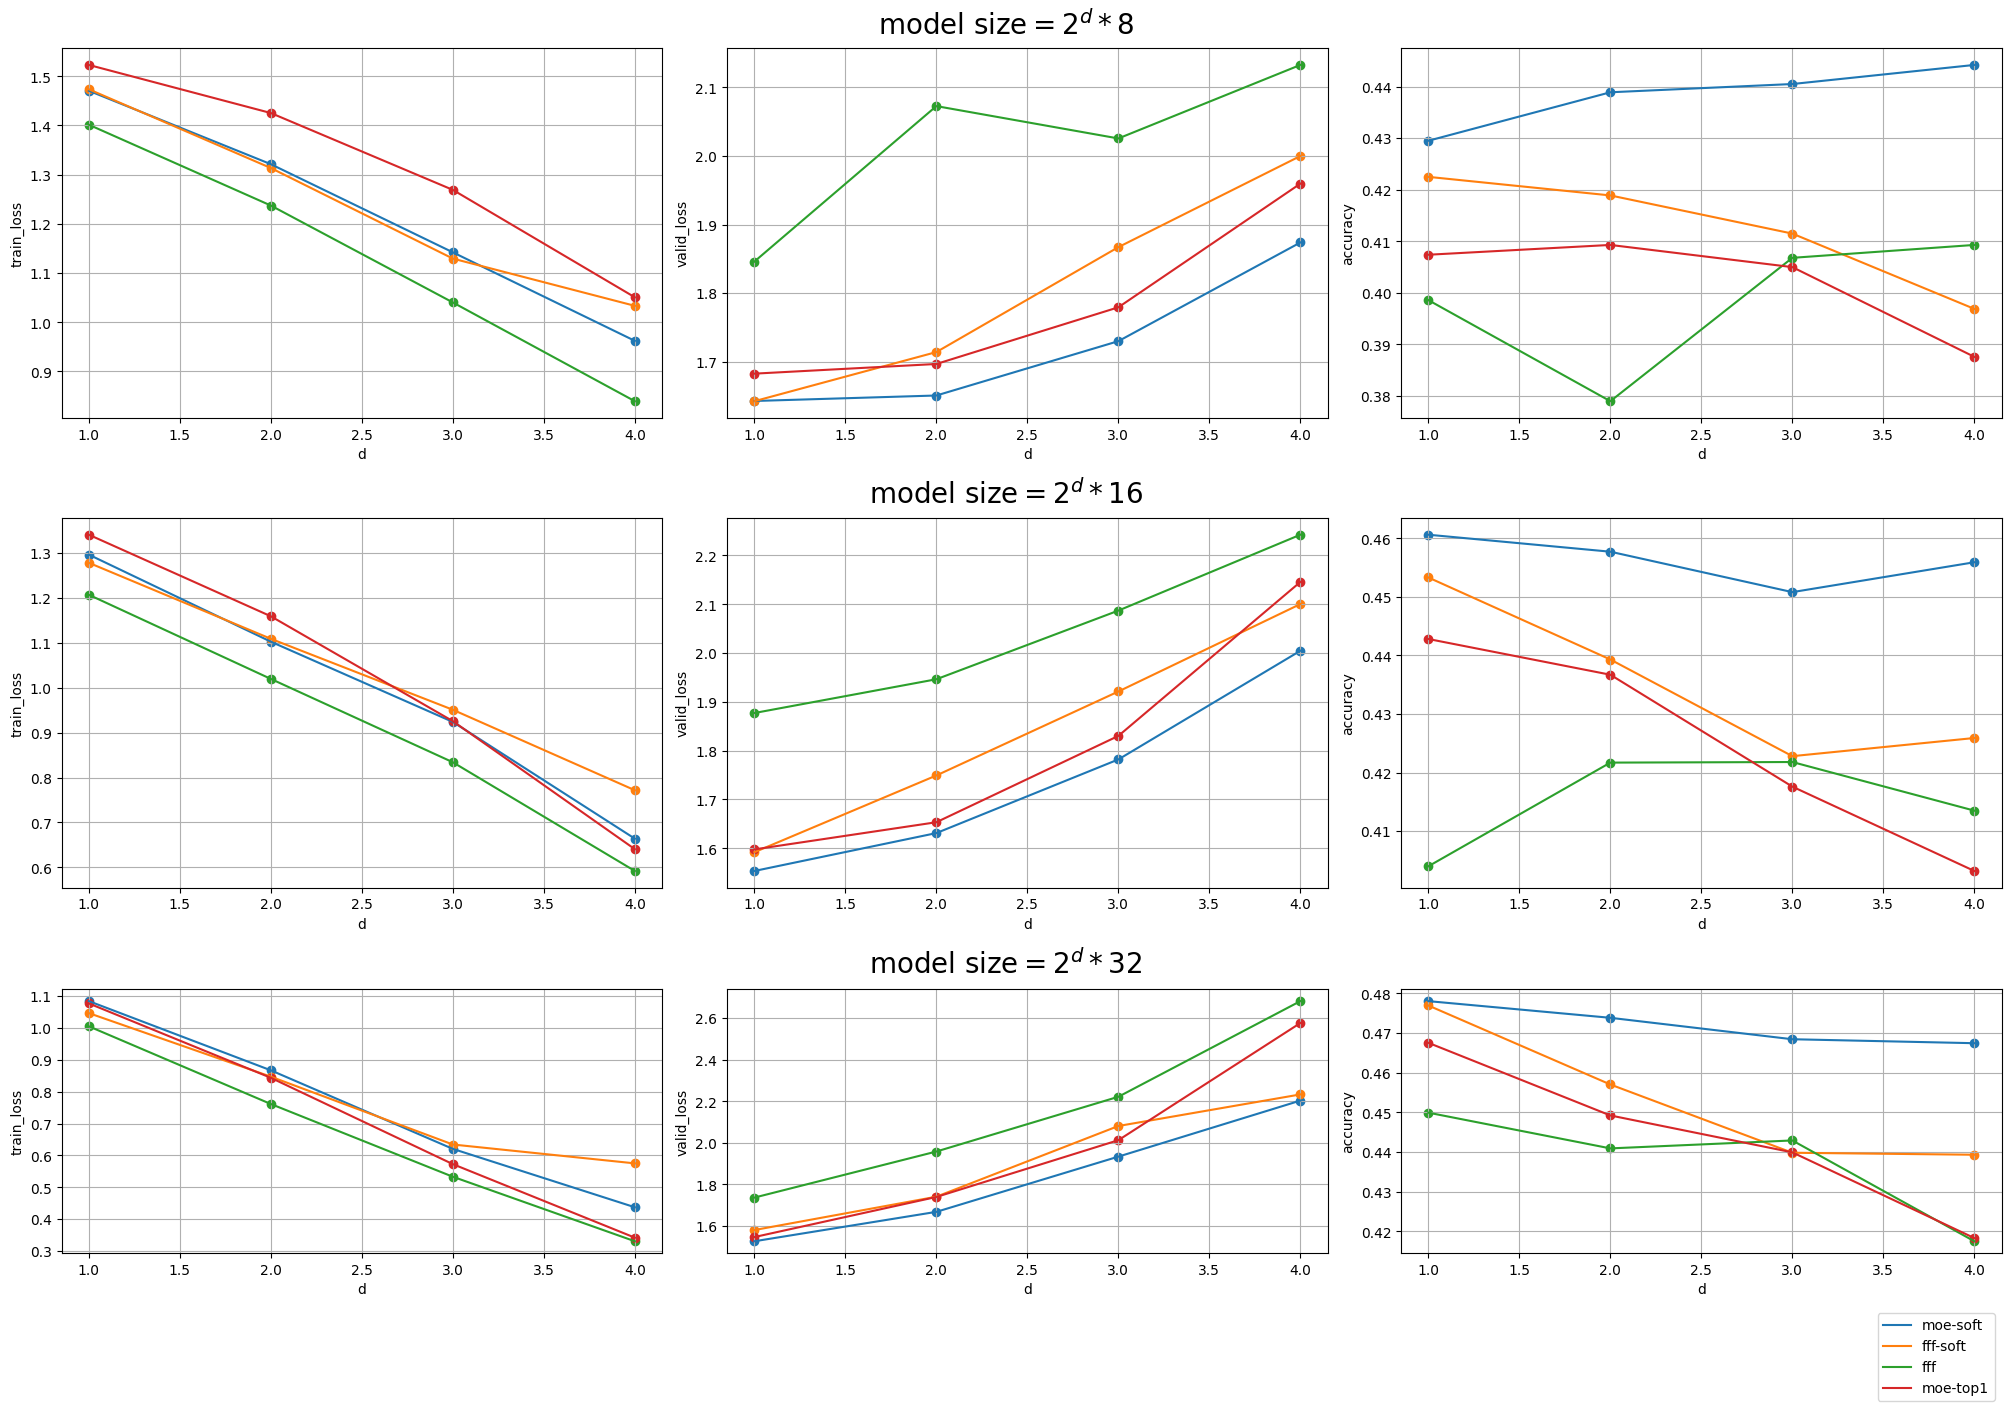

In [ ]:
hs = [8, 16, 32]
fig = plt.figure(constrained_layout=True, figsize=(20,14))
subfigs = fig.subfigures(nrows=3, ncols=1)
for i, f in enumerate(subfigs):
    f.suptitle(f'$\\text{{model size}}=2^d*{hs[i]}$',size=20)
    axes = f.subplots(nrows=1, ncols=len(metrics))
    d = {'h': hs[i]}
    plot_summary(d, axes)
plt.legend(bbox_to_anchor=(1, -0.2))